In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [6]:
%store -r X_motion_CoM_acceleration
%store -r Y_motion_CoM_acceleration
%store -r X_motion_CoM_continuous
%store -r Y_motion_CoM_continuous

X_motion_CoM = np.vstack((X_motion_CoM_acceleration, X_motion_CoM_continuous))
Y_motion_CoM = np.vstack((Y_motion_CoM_acceleration, Y_motion_CoM_continuous))

print(X_motion_CoM.shape)
print(Y_motion_CoM.shape)

(6432, 24)
(6432, 3)


In [7]:
X_motion_CoM[0, :]

array([0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.24436159431934357,
       0.1244141012430191, -0.3833571970462799, 0.2350023090839386,
       -0.12606710195541382, -0.38182950019836426, -0.259377658367157,
       0.12619635462760925, -0.3904612958431244, -0.2547312378883362,
       -0.12715134024620056, -0.3814551532268524, 0.014118616469204426,
       -0.009002149105072021, -0.017057212069630623, 0.05393084138631821,
       False, True], dtype=object)

# Multivariate Linear Regression (Foot prediction)

In [8]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [9]:
# Entries where FL foot is swinging
idx_fl_rr_swinging = np.where(X_motion_CoM[:, -2] == 1)[0]
X_motion_CoM_FL_RR = X_motion_CoM[idx_fl_rr_swinging]
Y_motion_CoM_FL_RR = Y_motion_CoM[idx_fl_rr_swinging]

In [10]:
idx_fl_rr_swinging.shape

(3214,)

In [11]:
X_motion_CoM_FL_RR[0, :]

array([0.1, 0.0, 0.0, 0.1, 0.0, 0.0, 0.22449669241905212,
       0.12662343680858612, -0.382874071598053, 0.2544834613800049,
       -0.12627078592777252, -0.3668656349182129, -0.24338990449905396,
       0.12268152087926865, -0.3708420395851135, -0.2726101279258728,
       -0.1296282857656479, -0.3834664225578308, 0.11076179891824722,
       -0.004943861160427332, -0.05758816748857498, -0.004658695310354233,
       True, False], dtype=object)

In [12]:
Y_motion_CoM_FL_RR[0, :]

array([0.03560406885803946, 0.0026476900498650924, 0.00020080044765265204],
      dtype=object)

## Predict CoM -> x

### Linear Regression

In [60]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, :3], # Previous motion command
               X_motion_CoM_FL_RR[:, 3:6], # Current motion command
               X_motion_CoM_FL_RR[:, 18:20], # Current CoM (x,y) veloctiy
               X_motion_CoM_FL_RR[:, 6:8], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 9:11], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 12:14], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 15:17])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_x = LinearRegression()

# Fit the model
model_fl_com_x.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))0.04954298

R2:  0.9749347522077694
RMSE:  0.009863341185930203
The lowest error is:  3.1678646931210253e-06
The highest error is:  0.03826854042892974
The avg. error is:  0.007232561635529456


In [61]:
model_fl_com_x.coef_

array([[ 4.23398187e-03, -2.77555756e-17,  0.00000000e+00,
         7.83002994e-02, -2.22044605e-16,  8.32667268e-17,
         2.67804670e-01,  1.02082579e-01,  2.13541135e-01,
        -1.50572681e-01, -4.14960068e-02,  5.04224747e-01,
        -4.57256935e-01,  7.32038091e-02, -4.25933617e-01,
        -1.55125911e-02]])

In [62]:
model_fl_com_x.intercept_

array([-0.19632036])

In [44]:
input_ = np.array([[0.0,0.0,0.0,0.1,0.0,0.0,0.2399, 0.134, 0.2399, -0.134, -0.2399, 0.134, -0.2399, -0.134]])
input_ @ model_fl_com_x.coef_.T + model_fl_com_x.intercept_

array([[-0.0246437]])

Text(0, 0.5, 'Predictions')

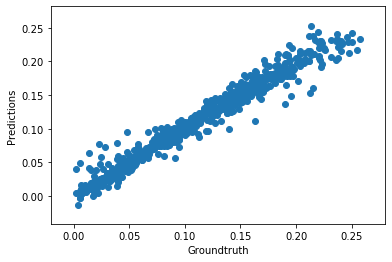

In [45]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [46]:
#%store model_fl_com_x

In [47]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [48]:
# Save model
#joblib.dump(model_fl_com_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_com_x.sav")

## Predict CoM -> y

### Linear Regression

In [63]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, :3], # Previous motion command
               X_motion_CoM_FL_RR[:, 3:6], # Current motion command
               X_motion_CoM_FL_RR[:, 18:20], # Current CoM (x,y) veloctiy
               X_motion_CoM_FL_RR[:, 6:8], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 9:11], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 12:14], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 15:17])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_y = LinearRegression()

# Fit the model
model_fl_com_y.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.4805790619487311
RMSE:  0.0035327864498513367
The lowest error is:  2.5541748889523763e-07
The highest error is:  0.022784442887807732
The avg. error is:  0.0026697188357771625


In [64]:
model_fl_com_y.coef_

array([[ 2.67952368e-03,  3.20923843e-17,  5.20417043e-17,
        -5.62770522e-03, -9.71445147e-17,  1.38777878e-17,
         5.87794034e-02,  7.86379352e-02,  4.04640266e-02,
        -3.40831609e-01,  4.27199226e-02,  4.10434319e-02,
        -2.90014998e-01,  1.91999361e-01, -1.51538816e-02,
         2.72263238e-02]])

In [65]:
model_fl_com_y.intercept_

array([-0.07201542])

Text(0, 0.5, 'Predictions')

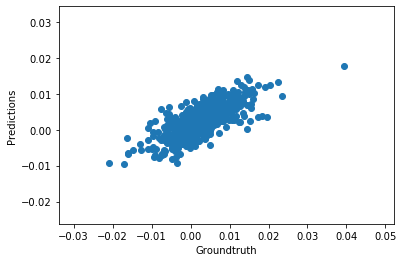

In [52]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [53]:
#%store model_fl_com_y

In [54]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [55]:
# Save model
#joblib.dump(model_fl_com_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_com_y.sav")

## Predict CoM -> Yaw

In [66]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, :3], # Previous motion command
               X_motion_CoM_FL_RR[:, 3:6], # Current motion command
               X_motion_CoM_FL_RR[:, 18:20], # Current CoM (x,y) veloctiy
               X_motion_CoM_FL_RR[:, 6:8], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 9:11], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 12:14], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 15:17])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_theta = LinearRegression()

# Fit the model
model_fl_com_theta.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_theta.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.1041924537636465
RMSE:  0.0023287008472881706
The lowest error is:  2.761732799588801e-06
The highest error is:  0.012780333597442378
The avg. error is:  0.0017867331671292525


In [67]:
model_fl_com_theta.coef_

array([[ 6.77559187e-05, -3.46944695e-17,  1.23599048e-17,
        -4.87601583e-04,  5.20417043e-18,  1.38777878e-17,
        -1.10366988e-02, -1.02079223e-02, -3.49861293e-03,
        -4.55599310e-02,  2.43856283e-02, -2.88568813e-02,
         2.27764720e-02, -4.40517832e-02,  5.40398150e-02,
         7.07807200e-02]])

In [68]:
model_fl_com_theta.intercept_

array([0.03430259])

Text(0, 0.5, 'Predictions')

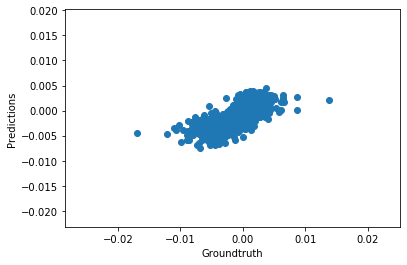

In [59]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")